<a href="https://colab.research.google.com/github/mneedham/data-science-training/blob/master/02_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis

In this notebook we're going to explore the citation dataset that we we imported in the previous notebook. As with the previous notebook let's install and import py2neo and pandas. We'll also install matplotlib to create some charts showing us the shape of the data.

In [1]:
!pip install py2neo pandas matplotlib

And let's import those libraries:

In [2]:
from py2neo import Graph
import pandas as pd

import matplotlib 
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)


Update the cell below with the same Sandbox credentials that you used in the first notebook:

In [3]:
# Change the line of code below to use the IP Address, Bolt Port, and Password of your Sandbox.
# graph = Graph("bolt://<IP Address>:<Bolt Port>", auth=("neo4j", "<Password>")) 

# graph = Graph("bolt://18.234.168.45:33679", auth=("neo4j", "daybreak-cosal-rumbles")) 
graph = Graph("bolt://data-science-training-neo4j", auth=("neo4j", "admin")) 

## What's in our database?

Now we can run the following query to check how many nodes our database contains:

In [4]:
graph.run("CALL db.schema()").data()

[{'nodes': [(_-3:Venue {constraints: ['CONSTRAINT ON ( venue:Venue ) ASSERT venue.name IS UNIQUE'], indexes: [], name: 'Venue'}),
   (_-1:Article {constraints: ['CONSTRAINT ON ( article:Article ) ASSERT article.index IS UNIQUE'], indexes: [], name: 'Article'}),
   (_-2:Author {constraints: ['CONSTRAINT ON ( author:Author ) ASSERT author.name IS UNIQUE'], indexes: [], name: 'Author'})],
  'relationships': [(Article)-[:VENUE {}]->(Venue),
   (Article)-[:AUTHOR {}]->(Author),
   (Article)-[:CITED {}]->(Article)]}]

If we run that query in the Neo4j Browser, we'll see the following visualisation:

<img src="images/data-science-training.png" alt="Graph Data Model"/>


Let's drill down a bit. How many nodes do we have for each of these labels?

In [5]:
result = {"label": [], "count": []}
for label in graph.run("CALL db.labels()").to_series():
    query = f"MATCH (:`{label}`) RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["label"].append(label)
    result["count"].append(count)
nodes_df = pd.DataFrame(data=result)
nodes_df.sort_values("count")

,label,count
2,Venue,4
1,Author,80299
0,Article,184313


We can visualize this counts using matplotlib with the following code:

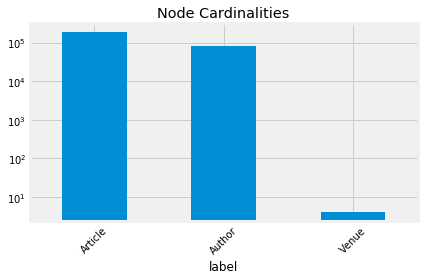

In [6]:
nodes_df.plot(kind='bar', x='label', y='count', legend=None, title="Node Cardinalities")
plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

And what types of relationships do we have?

In [7]:
result = {"relType": [], "count": []}
for relationship_type in graph.run("CALL db.relationshipTypes()").to_series():
    query = f"MATCH ()-[:`{relationship_type}`]->() RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["relType"].append(relationship_type)
    result["count"].append(count)
rels_df = pd.DataFrame(data=result)
rels_df.sort_values("count")

,relType,count
0,VENUE,51956
1,AUTHOR,140575
2,CITED,289908


We can visualize this counts using matplotlib with the following code:

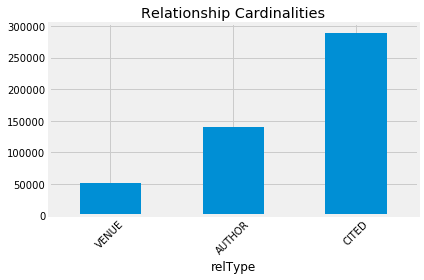

In [8]:
rels_df.plot(kind='bar', x='relType', y='count', legend=None, title="Relationship Cardinalities")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Now let's explore the citation data. The following query finds 25 authors, articles, venues, and also shows the number of articles that article has cited, as well as the number of articles that it's been cited by.

In [9]:
exploratory_query = """
MATCH (author:Author)<-[:AUTHOR]-(article:Article)-[:VENUE]->(venue)
RETURN article.title AS article, author.name AS author, venue.name AS venue, 
       size((article)-[:CITED]->()) AS citationsGiven, size((article)<-[:CITED]-()) AS citationsReceived
ORDER BY rand()
LIMIT 25
"""

graph.run(exploratory_query).to_data_frame()

,article,author,citationsGiven,citationsReceived,venue
0,A new algorithm of gray watermark embedding,Yongzeng Shen,2,0,Lecture Notes in Computer Science
1,Agent-based geo-simulation to support human pl...,Nabil Sahli,0,0,Lecture Notes in Computer Science
2,A Convex Hull-Based Fuzzy Regression to Inform...,Junzo Watada,9,0,international conference on software engineering
3,Hybrid test data generation,Qingkai Shi,6,0,international conference on software engineering
4,Classifier Conditional Posterior Probabilities,Robert P. W. Duin,4,5,Lecture Notes in Computer Science
5,Inferring multidimensional cubes for represent...,Roxana Danger,0,0,Lecture Notes in Computer Science
6,Remarks on Algorithm 332: Jacobi polynomials: ...,Arthur H. J. Sale,0,0,Communications of The ACM
7,Design Methodology for Web Services and Busine...,Jian Yang,1,1,Lecture Notes in Computer Science
8,Operation of residential hybrid renewable ener...,Ahmet Palazoglu,3,1,advances in computing and communications
9,Inductive Inference of Tree Automata by Recurs...,Giovanni Soda,8,0,Lecture Notes in Computer Science


Let's look into the citation data more closely.

In [10]:
query = """
MATCH (a:Article)
RETURN size((a)<-[:CITED]-()) AS citations
"""

citation_df = graph.run(query).to_data_frame()
citation_df.describe([.25, .5, .75, .9, .99])

,citations
count,184313.000
mean,1.573
std,3.386
min,0.000
25%,1.000
50%,1.000
75%,2.000
90%,3.000
99%,12.000
max,276.000


Most articles are being cited very few times. 75% of articles have 3 citations or less. We do, however, have one article that's been cited more than 1,000 times. We'll use a log scale histogram to visualise the data;

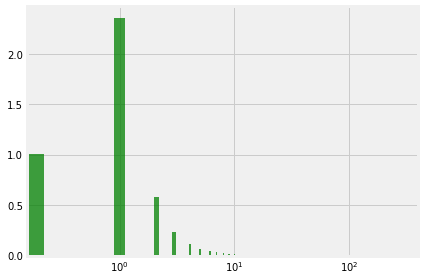

In [11]:
fig1, ax1 = plt.subplots()
ax1.hist(pd.Series(citation_df['citations'].dropna()), 1250, density=True, facecolor='g', alpha=0.75)
ax1.set_xscale("log")
plt.tight_layout()
plt.show()

## Exercise

* Can you create a similar chart showing the articles that cite the most other papers?
* What about a distribution of the number of articles published by authors?